<a href="https://colab.research.google.com/github/cjy-sc11/2025_machine_learning/blob/main/Week_6/AS6_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import xml.etree.ElementTree as ET
import csv

# 解析 XML 檔案
tree = ET.parse('O-A0038-003.xml')
root = tree.getroot()

# 從 XML 中提取原始數據
namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
content = root.find('.//cwa:Content', namespace).text.strip()
grid_data = [row.split(',') for row in content.split('\n')]

# 初始參數設定
start_lon = 120.00  # 起始經度
start_lat = 21.88    # 起始緯度
resolution = 0.03    # 解析度
cols = 67            # 經度方向格點數
rows = 120           # 緯度方向格點數

# 初始化數據集
classification = []
regression = []

# 處理格點數據
for row_idx in range(rows):
    current_lat = start_lat + row_idx * resolution
    for col_idx in range(cols):
        current_lon = start_lon + col_idx * resolution

        # 解析科學記號數值
        value_str = grid_data[row_idx][col_idx].strip()
        value = float(value_str)

        # 分類數據集處理
        label = 1 if value != -999.0 else 0
        classification.append([
            round(current_lon, 5),
            round(current_lat, 5),
            label
        ])

        # 回歸數據集處理 (只保留有效值)
        if value != -999.0:
            regression.append([
                round(current_lon, 5),
                round(current_lat, 5),
                round(value, 1)
            ])

# 保存分類數據集
with open('temperature_classification.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Longitude', 'Latitude', 'Label'])
    writer.writerows(classification)

# 保存回歸數據集
with open('temperature_regression.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Longitude', 'Latitude', 'Temperature'])
    writer.writerows(regression)

print('數據轉換完成！')
print(f'分類數據集數量：{len(classification)} 筆')
print(f'回歸數據集數量：{len(regression)} 筆')


數據轉換完成！
分類數據集數量：8040 筆
回歸數據集數量：3495 筆


訓練集大小: 6432 筆
測試集大小: 1608 筆

模型訓練完成。學習到的參數：
Phi (P(y=1)): 0.4347
Mu_0 (類別 0 平均值): [121.00976073  23.60537954]
Mu_1 (類別 1 平均值): [120.97185622  23.74270386]
Sigma (共用協方差矩陣):
[[0.33455285 0.00436058]
 [0.00436058 1.08052832]]

--- 模型性能評估 ---
模型在測試集上的準確度 (Accuracy): 0.5354 (53.54%)

正在繪製決策邊界圖...


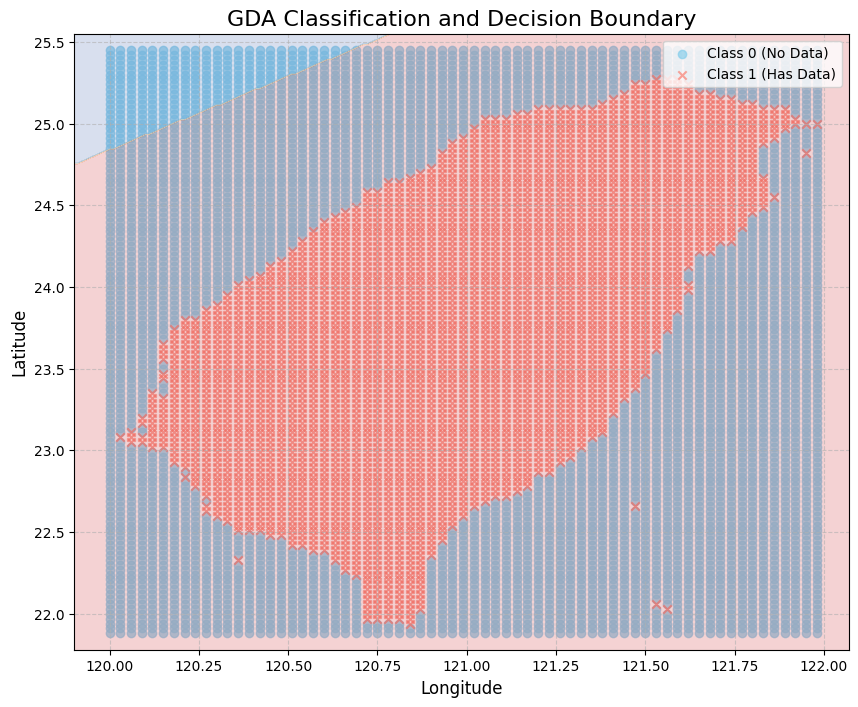

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


class GDA:
    """
    Gaussian Discriminant Analysis (GDA) classifier.

    Assumes a shared covariance matrix for all classes (leading to a
    linear decision boundary, i.e., LDA).
    """
    def __init__(self):
        self.phi = None
        self.mu0 = None
        self.mu1 = None
        self.sigma = None

    def fit(self, X, y):
        """
        Fit the GDA model by estimating parameters phi, mu_0, mu_1, and Sigma.

        Args:
            X (np.ndarray): Training data of shape (n_samples, n_features).
            y (np.ndarray): Target labels of shape (n_samples,).
        """
        n_samples, n_features = X.shape

        # 1. 計算 phi (p(y=1))
        # 這裡的 y 應該是 0 或 1 的值
        self.phi = np.mean(y)

        # 2. 計算 mu_0 和 mu_1
        # X[y == 0] 會選出所有標籤為 0 的樣本
        self.mu0 = np.mean(X[y == 0], axis=0)
        self.mu1 = np.mean(X[y == 1], axis=0)

        # 3. 計算共用的協方差矩陣 Sigma
        # 分別計算兩個類別的協方差矩陣然後加權平均
        sigma_0 = np.cov(X[y == 0].T, bias=True)
        sigma_1 = np.cov(X[y == 1].T, bias=True)

        # 根據樣本數加權
        n0 = np.sum(y == 0)
        n1 = np.sum(y == 1)
        self.sigma = (n0 * sigma_0 + n1 * sigma_1) / n_samples


    def predict(self, X):
        """
        Make predictions for new data points X.

        Args:
            X (np.ndarray): Data to predict of shape (n_samples, n_features).

        Returns:
            np.ndarray: Predicted labels (0 or 1).
        """
        if self.phi is None or self.mu0 is None or self.mu1 is None or self.sigma is None:
            raise RuntimeError("You must train the model with fit() before predicting.")

        # 為了避免計算高斯機率密度函數中複雜的常數項，
        # 我們可以直接比較 log(p(x|y)p(y)) 的大小。
        # log p(y=1|x) > log p(y=0|x)  =>  預測為 1

        sigma_inv = np.linalg.inv(self.sigma)

        # 計算分數 (與 log posterior 成正比)
        # score_k = x.T @ Sigma_inv @ mu_k - 0.5 * mu_k.T @ Sigma_inv @ mu_k + log(phi_k)
        term1_0 = X @ sigma_inv @ self.mu0
        term2_0 = 0.5 * self.mu0.T @ sigma_inv @ self.mu0
        term3_0 = np.log(1 - self.phi)
        score_0 = term1_0 - term2_0 + term3_0

        term1_1 = X @ sigma_inv @ self.mu1
        term2_1 = 0.5 * self.mu1.T @ sigma_inv @ self.mu1
        term3_1 = np.log(self.phi)
        score_1 = term1_1 - term2_1 + term3_1

        # 如果 score_1 > score_0，則預測為 1，否則為 0
        return (score_1 > score_0).astype(int)

# ======================================================================

# 1. 載入資料
df = pd.read_csv('temperature_classification.csv')


X = df[['Longitude', 'Latitude']].values
y = df['Label'].values

# 2. 將資料分割為訓練集和測試集
# 我們將使用 80% 的資料進行訓練，20% 的資料進行測試。
# random_state 確保每次分割的結果都一樣，方便重現實驗。
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape[0]} 筆")
print(f"測試集大小: {X_test.shape[0]} 筆")

# 3. 訓練 GDA 模型
gda_model = GDA()
gda_model.fit(X_train, y_train)
print("\n模型訓練完成。學習到的參數：")
print(f"Phi (P(y=1)): {gda_model.phi:.4f}")
print(f"Mu_0 (類別 0 平均值): {gda_model.mu0}")
print(f"Mu_1 (類別 1 平均值): {gda_model.mu1}")
print(f"Sigma (共用協方差矩陣):\n{gda_model.sigma}")


# 4. 評估模型性能
# 我們在**測試集(Test Set)**上評估模型的準確度，
# 這樣可以衡量模型對未見過數據的泛化能力。
# 準確度 = (預測正確的樣本數) / (總測試樣本數)
y_pred = gda_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)

print("\n--- 模型性能評估 ---")
print(f"模型在測試集上的準確度 (Accuracy): {accuracy:.4f} ({accuracy * 100:.2f}%)")

# 5. 繪製決策邊界
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(10, 8))

    # 繪製資料點
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='skyblue', label='Class 0 (No Data)', marker='o', alpha=0.7)
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='salmon', label='Class 1 (Has Data)', marker='x', alpha=0.7)

    # 建立網格來繪製決策邊界
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # 對網格中的每個點進行預測
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # 繪製等高線圖來顯示決策區域
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.RdYlBu)

    plt.title('GDA Classification and Decision Boundary', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

print("\n正在繪製決策邊界圖...")
# 我們使用完整的資料集來繪圖，以獲得更全面的視覺效果
plot_decision_boundary(gda_model, X, y)

--- 開始訓練分類模型 C(x) [RandomForestClassifier] ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
分類模型訓練完成。耗時: 192.44 秒
最佳分類器交叉驗證準確率: 0.6739

--- 開始訓練迴歸模型 R(x) [GradientBoostingRegressor] ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
迴歸模型訓練完成。耗時: 203.24 秒
最佳迴歸器交叉驗證 R² 分數: -0.5815

任務二：驗證組合模型 h(x) 的行為
組合模型 h(x) 預測結果抽樣驗證表：

    Longitude  Latitude  C(x) -> Class  h(x) -> Output
0      120.72     23.35              1           17.68
1      121.62     25.03              1           26.54
2      121.92     24.19              0         -999.00
3      121.65     22.78              0         -999.00
4      120.51     23.47              1           22.93
5      120.84     23.44              1           15.22
6      120.39     21.88              0         -999.00
7      120.72     25.21              0         -999.00
8      120.99     25.06              0         -999.00
9      121.44     24.85              1           24.82
10     120.54     24.22              1  

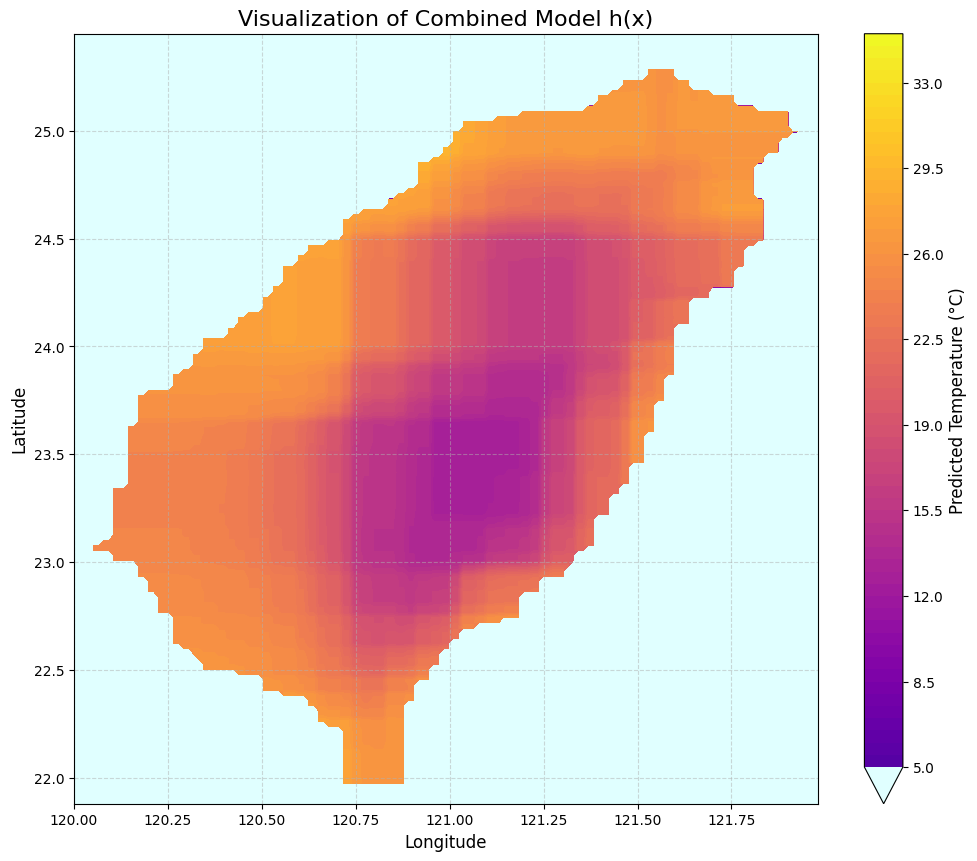

In [6]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from scipy.stats import randint, uniform
import time

# ======================================================================
# 模型訓練核心 (來自第四次作業)
# C(x) -> RandomForestClassifier
# R(x) -> GradientBoostingRegressor
# ======================================================================
class ModelTrainer:
    def __init__(self):
        # 用於 C(x) 的隨機森林分類器的超參數搜索空間
        self.clf_params = {
            'n_estimators': randint(100, 500),
            'max_depth': randint(5, 15),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }

        # 用於 R(x) 的梯度提升迴歸器的超參數搜索空間
        self.reg_params = {
            'n_estimators': randint(200, 800),
            'learning_rate': uniform(0.01, 0.2),
            'max_depth': randint(3, 10),
            'subsample': uniform(0.7, 0.3) # 0.7 + 0.3 = 1.0
        }

    def train_classifier(self, X, y):
        """訓練並優化分類模型 C(x)"""
        print("--- 開始訓練分類模型 C(x) [RandomForestClassifier] ---")
        start_time = time.time()
        # 使用 RandomizedSearchCV 尋找最佳模型
        search = RandomizedSearchCV(
            estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
            param_distributions=self.clf_params,
            n_iter=30,  # 增加迭代次數以獲得更好的模型
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        search.fit(X, y)
        print(f"分類模型訓練完成。耗時: {time.time() - start_time:.2f} 秒")
        print(f"最佳分類器交叉驗證準確率: {search.best_score_:.4f}\n")
        return search.best_estimator_

    def train_regressor(self, X, y):
        """訓練並優化迴歸模型 R(x)"""
        print("--- 開始訓練迴歸模型 R(x) [GradientBoostingRegressor] ---")
        start_time = time.time()
        # 使用 RandomizedSearchCV 尋找最佳模型
        search = RandomizedSearchCV(
            estimator=GradientBoostingRegressor(random_state=42),
            param_distributions=self.reg_params,
            n_iter=30,
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        search.fit(X, y)
        print(f"迴歸模型訓練完成。耗時: {time.time() - start_time:.2f} 秒")
        print(f"最佳迴歸器交叉驗證 R² 分數: {search.best_score_:.4f}\n")
        return search.best_estimator_

# ======================================================================
# 任務二-a: 實現組合模型 h(x)
# ======================================================================
def predict_h_model(X_input, C_model, R_model):
    """
    實現組合模型 h(x) 的預測功能。

    Args:
        X_input (np.ndarray): 輸入的特徵數據 (經緯度)。
        C_model: 訓練好的分類模型 C(x) (e.g., RandomForestClassifier)。
        R_model: 訓練好的迴歸模型 R(x) (e.g., GradientBoostingRegressor)。

    Returns:
        np.ndarray: 組合模型的預測結果。
    """
    # 步驟 1: 使用分類模型 C(x) 進行預測
    class_predictions = C_model.predict(X_input)

    # 步驟 2: 初始化一個填滿 -999 的結果陣列 (處理 C(x)=0 的情況)
    final_predictions = np.full(X_input.shape[0], -999.0, dtype=float)

    # 步驟 3: 找出 C(x) 預測為 1 的資料點
    is_class_1_mask = (class_predictions == 1)

    # 步驟 4: 只對 C(x)=1 的資料點使用迴歸模型 R(x) 進行預測
    if np.any(is_class_1_mask):
        regression_inputs = X_input[is_class_1_mask]
        regression_predictions = R_model.predict(regression_inputs)

        # 步驟 5: 將 R(x) 的預測結果填入最終結果陣列的對應位置
        final_predictions[is_class_1_mask] = regression_predictions

    return final_predictions

# ======================================================================
# 主要執行流程
# ======================================================================
if __name__ == "__main__":
    # --- 1. 載入資料 ---
    try:
        df_class = pd.read_csv('temperature_classification.csv')
        df_reg = pd.read_csv('temperature_regression.csv')
    except FileNotFoundError as e:
        print(f"錯誤：找不到資料檔 {e.filename}。請先執行資料轉換程式碼。")
        sys.exit(1)

    # 分類模型的完整資料
    X_clf_all = df_class[['Longitude', 'Latitude']].values
    y_clf_all = df_class['Label'].values

    # 迴歸模型的完整資料
    X_reg_all = df_reg[['Longitude', 'Latitude']].values
    y_reg_all = df_reg['Temperature'].values

    # --- 2. 訓練模型 C(x) 和 R(x) (來自第四次作業) ---
    trainer = ModelTrainer()
    best_clf = trainer.train_classifier(X_clf_all, y_clf_all)
    best_reg = trainer.train_regressor(X_reg_all, y_reg_all)

    # --- 3. 任務二-b: 應用模型並用表格驗證 ---
    print("="*50)
    print("任務二：驗證組合模型 h(x) 的行為")
    print("="*50)

    # 隨機選取一些點來展示 (包含陸地和海洋)
    sample_indices = np.random.choice(len(X_clf_all), size=20, replace=False)
    X_sample = X_clf_all[sample_indices]

    h_predictions_sample = predict_h_model(X_sample, best_clf, best_reg)
    c_predictions_sample = best_clf.predict(X_sample)

    validation_df = pd.DataFrame({
        'Longitude': X_sample[:, 0],
        'Latitude': X_sample[:, 1],
        'C(x) -> Class': c_predictions_sample,
        'h(x) -> Output': h_predictions_sample
    })

    print("組合模型 h(x) 預測結果抽樣驗證表：\n")
    print(validation_df.round(2))
    print("\n[驗證成功] 當 C(x) 預測為 0 時, h(x) 輸出 -999；")
    print("當 C(x) 預測為 1 時, h(x) 輸出一個溫度預測值。\n")

    # --- 4. 任務二-d: 繪製視覺化圖表 ---
    print("--- 正在繪製組合模型 h(x) 的行為視覺化圖 (可能需要一點時間) ---")

    # 建立一個覆蓋整個區域的網格
    lon_min, lon_max = X_clf_all[:, 0].min(), X_clf_all[:, 0].max()
    lat_min, lat_max = X_clf_all[:, 1].min(), X_clf_all[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 150),
                         np.linspace(lat_min, lat_max, 150))

    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 對網格中所有點進行 h(x) 預測
    Z = predict_h_model(grid_points, best_clf, best_reg)
    Z = Z.reshape(xx.shape)

    # 繪圖
    plt.figure(figsize=(12, 10))

    # 使用 cmap.set_under 將 -999 的區域獨立出來，用特定顏色顯示
    cmap = plt.get_cmap('plasma').copy()
    cmap.set_under('lightcyan') # 將低於 vmin 的值設為淺青色

    # 設置 vmin=0，這樣所有 -999 都會被 set_under 處理
    contour = plt.contourf(xx, yy, Z, levels=np.linspace(5, 35, 61),
                           cmap=cmap, vmin=0, extend='min')

    cbar = plt.colorbar(contour)
    cbar.set_label('Predicted Temperature (°C)', fontsize=12)

    plt.title('Visualization of Combined Model h(x)', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    output_filename = 'combined_model_h_visualization.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\n視覺化圖表已儲存為 '{output_filename}'")

    plt.show()